### Setup

In [20]:
%pip install PySastrawi
import pandas as pd
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv('https://github.com/ibamibrahim/news-title-dataset/blob/master/detik_news_title.csv?raw=true')
df.head()

,date,url,title,category
0,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,Kemnaker Awasi TKA di Meikarta,finance
1,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,BNI Digitalkan BNI Java Jazz 2020,finance
2,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,"Terbang ke Australia, Edhy Prabowo Mau Genjot ...",finance
3,02/26/2020,https://finance.detik.com/moneter/d-4916133/oj...,OJK Siapkan Stimulus Ekonomi Antisipasi Dampak...,finance
4,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,Saran Buat Anies-RK yang Mangkir Rapat Banjir ...,finance


### Dataset Characteristic

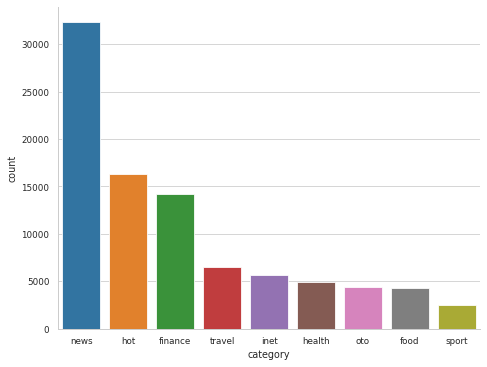

In [3]:
# Title distribution

sns.color_palette("hls", 8)
sns.set_style("whitegrid")
sns.set_context("paper")

temp = df.groupby(['category']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)
sns.catplot(x='category', y='count', kind='bar', data=temp, height=5, aspect=4/3)
plt.show()

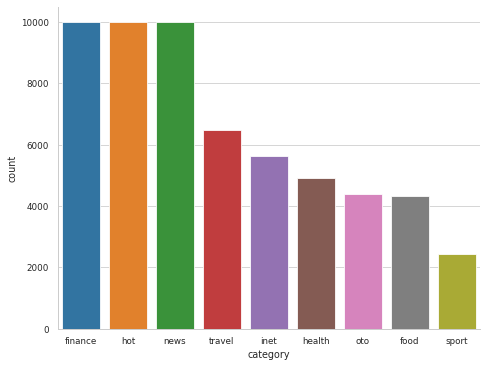

In [4]:
## Limit the number of data to 10000 per category

limit = 10000
df_category_count = df.groupby(['category']).size().reset_index().rename(columns={0:'data_count'})
for cat in df_category_count.category.unique():
    row_dropped = int(df_category_count[df_category_count.category == cat]['data_count'] - 10000)
    if row_dropped > 0:
        index_to_drop = np.random.choice(df[df.category == cat].index, size=row_dropped, replace=False)
        df = df.drop(index_to_drop)

temp = df.groupby(['category']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)
sns.catplot(x='category', y='count', kind='bar', data=temp, height=5, aspect=4/3)
plt.show()

### Data Split

In [5]:
X = df[['title']]
y = df[['category']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=42)

print(f'Training size: {X_train.shape}')
print(f'Testing size: {X_test.shape}')

Training size: (43619, 1)
Testing size: (14540, 1)


### Preprocessing

In this step, we will preprocess/clean the text. The steps are:

1. Case folding (case lowering, removing punctuation, removing numbers, and trailing space
2. Filtering (stopwords removal)
3. Normalization (stemming)

In [6]:
def preprocess(title, sw_remover, stemmer):

    ## Case Folding (sentence lowering, remove punctuation & numbers)
    title = title.lower()
    title = re.sub(r'\d+', '', title)
    title = title.translate(str.maketrans('', '', string.punctuation))
    title = title.strip()
    
    ## Filtering (Stopwords removal)
    title = sw_remover.remove(title)

    ## Stemming (Change to bsaic form)
    title = stemmer.stem(title)

    return title

sw_remover = StopWordRemoverFactory().create_stop_word_remover()
stemmer = StemmerFactory().create_stemmer()

X_train['title'] = X_train.title.apply(lambda text: preprocess(text, sw_remover, stemmer))
X_train[['title']][:20]

,title
82938,jadwal all england babak
67939,komisi viii menag sertifikasi majelis taklimpe...
83388,poin westbrook selamat rockets kalah
87598,salur irigasi spot river tubing ala sumedang
64826,operasi psbb khofifah anggap enteng sebar covi...
15995,heboh telur isi telur telur bentuk ulat telur ...
14204,beli produk heinz abc minimarket bantu donasi ...
19039,protes kurang apd dokter jerman ramairamai pos...
88985,foto seru petik buah kebun
40049,elon musk cuti twitter


### EDA

In [7]:
df_train = pd.merge(X_train, y_train, left_index=True, right_index=True)

#### Most words for each category

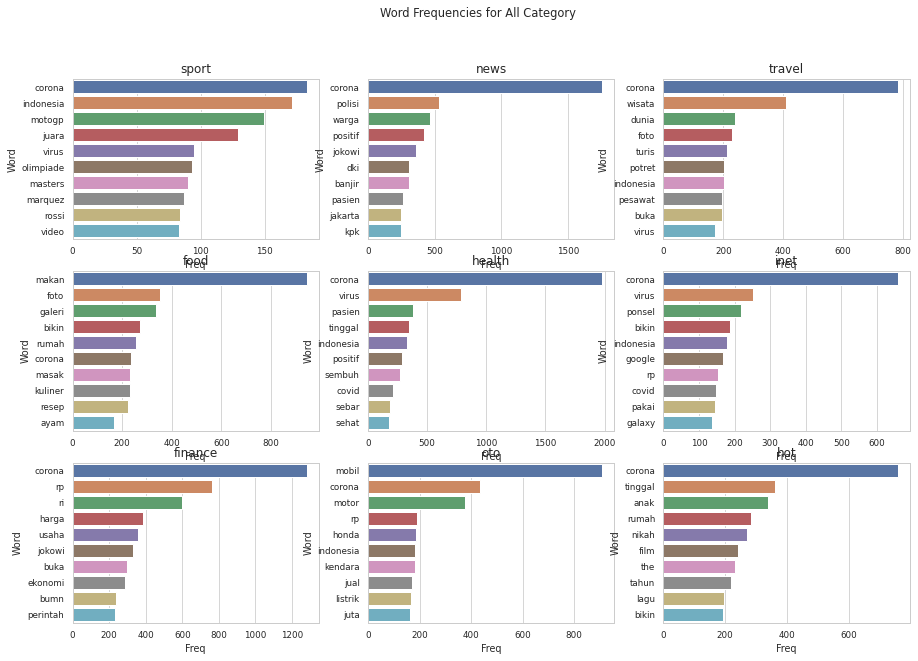

In [8]:
def get_top_words(data, category,axes,n=10):
    corpus = data[data.category == category]['title']
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    words_sum = bag_of_words.sum(axis=0)
    words_freq = [(word, words_sum[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    top_df = pd.DataFrame(words_freq[:n])
    top_df.columns=["Word", "Freq"]
    sns.set(rc={'figure.figsize':(15,8)})
    sns.barplot(ax=axes, x="Freq", y="Word", data=top_df)
    axes.set_title(category)

fig, axes = plt.subplots(3,3, figsize=(15,10))
fig.suptitle('Word Frequencies for All Category')
row = 0
col = 0
for cat in list(df_train.category.unique()):
    get_top_words(df_train, cat, axes[row, col])
    col += 1
    if col == 3:
        col = 0
        row += 1

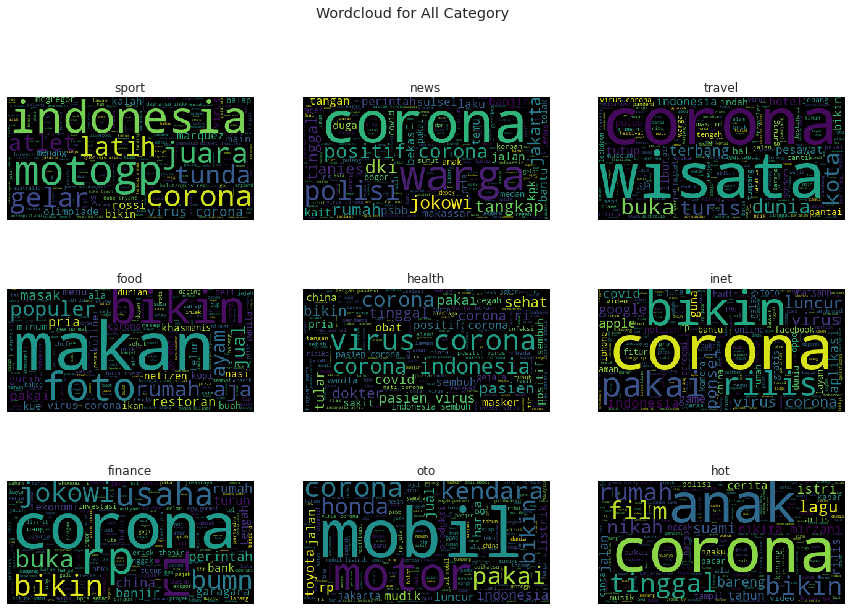

In [9]:
from wordcloud import WordCloud

def generate_wordcloud(data, category, axes):
    data = data[data.category == category].title.str.cat()
    w = WordCloud().generate(data)
    axes.imshow(w, interpolation='nearest')
    axes.axis('off')
    axes.set_title(category)

fig, axes = plt.subplots(3,3, figsize=(15,10))
fig.suptitle('Wordcloud for All Category')
row = 0
col = 0
for cat in list(df_train.category.unique()):
    generate_wordcloud(df_train, cat, axes[row, col])
    col += 1
    if col == 3:
        col = 0
        row += 1

#### Removing Corona from the Text

Since it is seems to be appeared everywhwhere

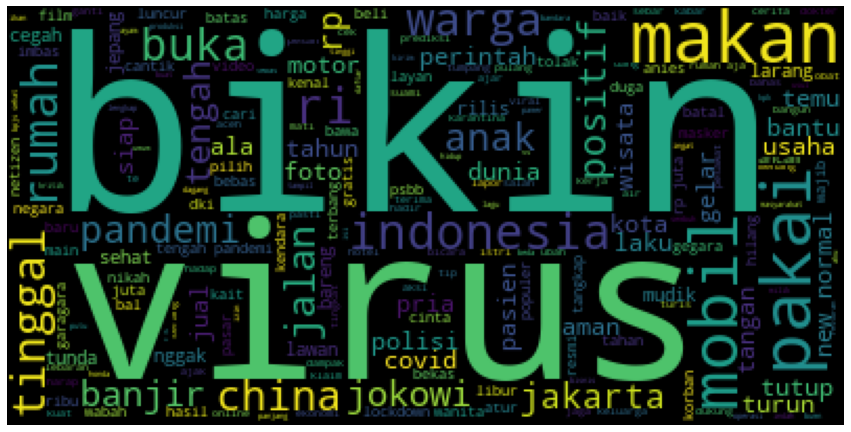

In [10]:
X_train['title'] = X_train['title'].str.replace('corona', '')
w = WordCloud().generate(X_train.title.str.cat())
plt.imshow(w)
plt.axis('off')
plt.show()

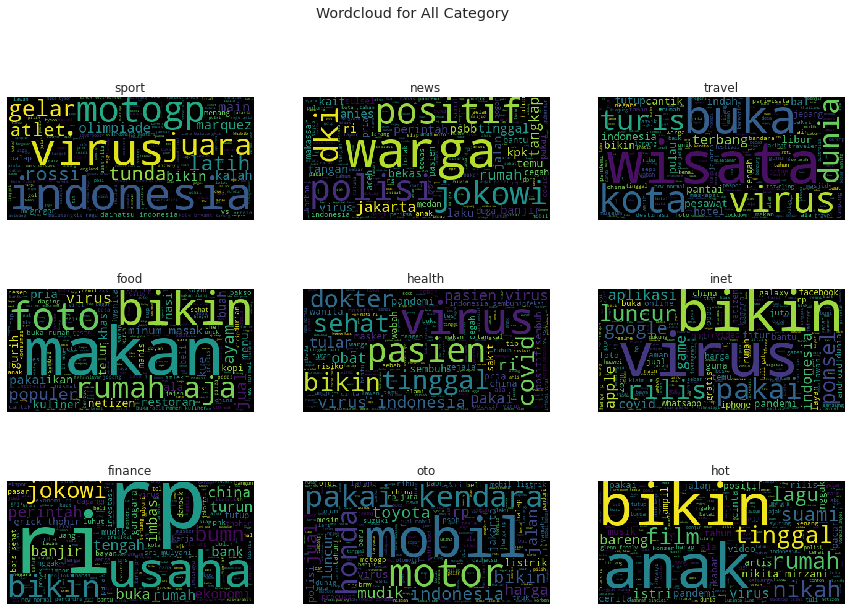

In [11]:
from wordcloud import WordCloud

def generate_wordcloud(data, category, axes):
    data = data[data.category == category].title.str.cat()
    w = WordCloud().generate(data)
    axes.imshow(w, interpolation='nearest')
    axes.axis('off')
    axes.set_title(category)

df_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
fig, axes = plt.subplots(3,3, figsize=(15,10))
fig.suptitle('Wordcloud for All Category')
row = 0
col = 0
for cat in list(df_train.category.unique()):
    generate_wordcloud(df_train, cat, axes[row, col])
    col += 1
    if col == 3:
        col = 0
        row += 1

### Modelling




In [12]:
## Credits to https://github.com/jkmackie/confusion_matrix_visualization
#@title ###Plot Confusion Matrix Helper Code
def plot_confusion_matrix(confusion_matrix, class_names, errors_only=False, figsize = (15,6), fontsize=16):
    """
    Plots confusion matrix as a color-encoded Seaborn heatmap.  Zeroes are
    colored white.  Normalized values that are zero when rounded to three
    decimals, Ex. 0.000, will be colored white.  Get more decicmals by
    updating fmt, for example to '0.4f', and updating get_text() value.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object sklearn.metrics.confusion_matrix. 
    class_names: list
        List of class names in the order they index the confusion matrix.
    figsize: tuple
        A pair tuple.  The first value is figure width.  The second
        value is figure height. Defaults to (15,6).
    fontsize: int
        Font size for axes labels. Defaults to 16.
    """        
    #Instantiate Figure
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    plt.subplots_adjust(wspace = 0.5)
    
    #Show errors only by filling diagonal with zeroes.
    if errors_only:
        np.fill_diagonal(confusion_matrix, 0)        
        
    # ax1 - Normalized Confusion Matrix    
    #Normalize by dividing (M X M) matrix by (M X 1) matrix.  (M X 1) is row totals.
    conf_matrix_norm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:,np.newaxis]
    conf_matrix_norm = np.nan_to_num(conf_matrix_norm)  #fix any nans caused by zero row total
    df_cm_norm = pd.DataFrame(conf_matrix_norm, index=class_names, columns=class_names)
    heatmap = sns.heatmap(df_cm_norm, ax=ax1, cmap='Blues', fmt='.2f', annot=True, annot_kws={"size": fontsize},
              linewidths=2, linecolor='black', cbar=False)
    
    ax1.tick_params(axis='x', labelrotation=0, labelsize=fontsize, labelcolor='black')
    ax1.tick_params(axis='y', labelrotation=0, labelsize=fontsize, labelcolor='black')
    ax1.set_ylim(ax1.get_xlim()[0], ax1.get_xlim()[1])  #Fix messed up ylim
    ax1.set_xlabel('PREDICTED CLASS', fontsize=fontsize, color='black')
    ax1.set_ylabel('TRUE CLASS', fontsize=fontsize, color='black')
    ax1.set_title('Confusion Matrix - Normalized', pad=15, fontsize=fontsize, color='black')
    
    # ax2 - Confusion Matrix - Class Counts
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)    
    heatmap = sns.heatmap(df_cm, ax=ax2, cmap='Blues', fmt='d', annot=True, annot_kws={"size": fontsize+4},
              linewidths=2, linecolor='black', cbar=False)   
    
    ax2.tick_params(axis='x', labelrotation=0, labelsize=fontsize, labelcolor='black')
    ax2.tick_params(axis='y', labelrotation=0, labelsize=fontsize, labelcolor='black')
    ax2.set_ylim(ax1.get_xlim()[0], ax1.get_xlim()[1])  #Fix bug in matplotlib 3.1.1.  Or, use earlier matplotlib.
    ax2.set_xlabel('PREDICTED CLASS', fontsize=fontsize, color='black')
    ax2.set_ylabel('TRUE CLASS', fontsize=fontsize, color='black')
    ax2.set_title('Confusion Matrix - Class Counts', pad=15, fontsize=fontsize, color='black')    
  
    for text in ax1.texts:
        if text.get_text() == '0.000':
            text.set_color(color='white')            
    for text in ax2.texts:
        if text.get_text() == '0':
            text.set_color(color='white')

#### Multimodel Using Gridsearch

In [13]:
from sklearn.model_selection import RandomizedSearchCV
class Classifier(object):
    def __init__(self, model, param, n_cv=5):
        self.model = model
        self.param = param
        self.gs = RandomizedSearchCV(self.model, self.param
                               , cv=n_cv, error_score=0, refit=True)
    
    def fit(self, X, y):
        return self.gs.fit(X,y)
    
    def cv_predict(self, X_train, y_train, cv=15):
        return cross_val_predict(self.gs, X_train, y_train, cv=cv)

    def get_gs(self):
        return self.gs

#### Bag of Words

In [16]:
config = {
    'lowercase':True,
    'ngram_range':(1,1),
    'analyzer': 'word',
    'max_features':10000
}
vectorizer_bow = CountVectorizer(**config)
X_train_bow = vectorizer_bow.fit_transform(X_train['title'])

clf_models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression()
}

clf_params = {
    'Naive Bayes': {
        'alpha':np.arange(0.5, 1.1, 0.1),
        'fit_prior': [True, False]
    }, 
    'Logistic Regression': {
        # 'tol': [1 / 10 ** 4, 1 / 10 ** 2],
        'C': np.arange(0.5, 1.1, 0.2),
        'solver': ['sag'],
        'max_iter': [250],
        'n_jobs': [-1]
    }
}

for key in list(clf_models.keys()):
    print(f'{key}')
    model = clf_models[key]
    param = clf_params[key]
    clf = Classifier(model, param, n_cv=5)
    print('---------- Fit the model using grid search')
    clf.fit(X_train_bow, y_train)
    print('---------- Predict the model using N fold Cv')
    y_train_pred = clf.cv_predict(X_train_bow, y_train, cv=5)
    gs = clf.get_gs()
    print(f'---------- Best Params {gs.best_params_}')
    print(f'---------- Accuracy : {accuracy_score(y_train, y_train_pred)}')
    print(f'---------- Precision : {precision_score(y_train, y_train_pred, average="macro")}')
    print(f"---------- Recall: {recall_score(y_train, y_train_pred, average='macro')}")
    print(f"---------- F1 Score: {f1_score(y_train, y_train_pred, average='macro')}")

Naive Bayes
---------- Fit the model using grid search
---------- Predict the model using N fold Cv
---------- Best Params {'fit_prior': True, 'alpha': 0.5}
---------- Accuracy : 0.8109310163002361
---------- Precision : 0.8096451815624925
---------- Recall: 0.8091299678594109
---------- F1 Score: 0.808530373409445
Logistic Regression
---------- Fit the model using grid search
---------- Predict the model using N fold Cv
---------- Best Params {'solver': 'sag', 'n_jobs': -1, 'max_iter': 250, 'C': 1.0999999999999999}
---------- Accuracy : 0.8192530777872028
---------- Precision : 0.8243572787215206
---------- Recall: 0.8101576269525902
---------- F1 Score: 0.8166609529802833


#### TF IDF

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_bow = TfidfVectorizer()
X_train_idf = vectorizer_bow.fit_transform(X_train['title'])
for key in list(clf_models.keys()):
    print(f'{key}')
    model = clf_models[key]
    param = clf_params[key]
    clf = Classifier(model, param, n_cv=5)
    print('---------- Fit the model using grid search')
    clf.fit(X_train_idf, y_train)
    print('---------- Predict the model using N fold Cv')
    y_train_pred = clf.cv_predict(X_train_idf, y_train, cv=5)
    gs = clf.get_gs()
    print(f'---------- Best Params {gs.best_params_}')
    print(f'---------- Accuracy : {accuracy_score(y_train, y_train_pred)}')
    print(f'---------- Precision : {precision_score(y_train, y_train_pred, average="macro")}')
    print(f"---------- Recall: {recall_score(y_train, y_train_pred, average='macro')}")
    print(f"---------- F1 Score: {f1_score(y_train, y_train_pred, average='macro')}")

Naive Bayes
---------- Fit the model using grid search
---------- Predict the model using N fold Cv
---------- Best Params {'fit_prior': False, 'alpha': 0.5}
---------- Accuracy : 0.8111144226139985
---------- Precision : 0.8078096764448301
---------- Recall: 0.8082272277651764
---------- F1 Score: 0.8072294049492008
Logistic Regression
---------- Fit the model using grid search
---------- Predict the model using N fold Cv
---------- Best Params {'solver': 'sag', 'n_jobs': -1, 'max_iter': 250, 'C': 1.0999999999999999}
---------- Accuracy : 0.8118480478690479
---------- Precision : 0.8258934877021868
---------- Recall: 0.7931680777561017
---------- F1 Score: 0.8072040474469301


#### Final Model


In [18]:
params = {'solver': 'sag', 'n_jobs': -1, 'max_iter': 250, 'C': 1.0999999999999999}
final_model = LogisticRegression(**params)
vectorizer = CountVectorizer(**config)
X_train_bow = vectorizer.fit_transform(X_train['title'])
final_model.fit(X_train_bow, y_train) 

LogisticRegression(C=1.0999999999999999, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=250, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

#### Testing on Test Set

---------- Accuracy : 0.8192572214580468
---------- Precision : 0.8233731748947728
---------- Recall: 0.8107430291495586
---------- F1 Score: 0.8163455041534798


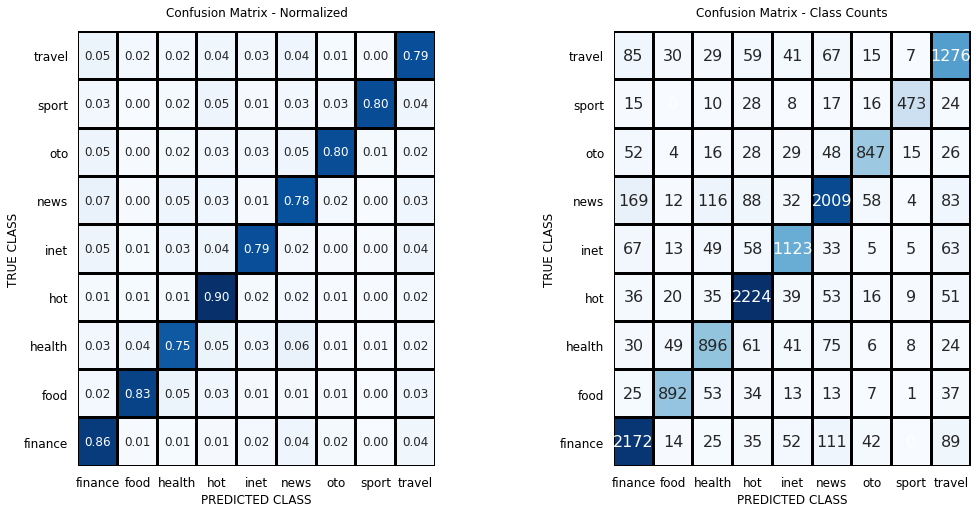

In [22]:
X_test['title'] = X_test.title.apply(lambda text: preprocess(text, sw_remover, stemmer))
X_test_bow = vectorizer.transform(X_test['title'])
y_test_pred = final_model.predict(X_test_bow)
print(f'---------- Accuracy : {accuracy_score(y_test, y_test_pred)}')
print(f'---------- Precision : {precision_score(y_test, y_test_pred, average="macro")}')
print(f"---------- Recall: {recall_score(y_test, y_test_pred, average='macro')}")
print(f"---------- F1 Score: {f1_score(y_test, y_test_pred, average='macro')}")
title = 'Confusion Matrix of Test Set'
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred),
                      final_model.classes_,
                      figsize=(16,8),
                      fontsize=12)

In [27]:
X_test['predicted'] = y_test_pred
X_test['label'] = y_test
print('Wrong Health Topic Classification')
X_test[(X_test.label == 'health') & (X_test.predicted == 'hot')][:15]

Wrong Health Topic Classification


,title,predicted,label
19459,olahraga rumah rumah banding untung rugi,hot,health
19801,interaksi disabiltas acara marketibility,hot,health
19942,raya lebaran dunia tengah pandemi corona,hot,health
21954,aman polisi ririn ekawati pil happy five,hot,health
21553,halhal perhati anak stres ajar rumah,hot,health
21180,viral sosok tante ernie olahraga inspirasi bugar,hot,health
23343,parno tular virus corona suami tega kunci istr...,hot,health
22346,rumah lelah,hot,health
18814,rapper eminem kabar virus corona fakta,hot,health
21338,reaksi tubuh cium,hot,health


#### Predicting on New Data

In [31]:
titles = ['Raffi Ahmad Ikut Pesta Usai Divaksin Tuai Pro dan Kontra', 
          '3 Resep Omelet Sayuran yang Praktis Benutrisi Buat Sarapan',
          'Chelsea berhasil mengalahkan liverpool',
          'Di Tengah Viral Raffi Ahmad Pesta Tanpa Masker, dr Reisa Nge-tweet Begini',
          'Resort Cakep Berkonsep Pedesaan di Cirebon, Manusia Ikan Pecahkan Rekor',
          'Real Madrid Bakal Lawan Atalanta yang Retak',
          'Ekonomi Rontok Kena Dampak Corona, Bagaimana Bisnis Budi Daya Ikan?']

for t in titles:
    title = preprocess(t, sw_remover, stemmer)
    title = vectorizer.transform([title])
    print(t, '----', (final_model.predict(title))[0])

Raffi Ahmad Ikut Pesta Usai Divaksin Tuai Pro dan Kontra ---- hot
3 Resep Omelet Sayuran yang Praktis Benutrisi Buat Sarapan ---- food
Chelsea berhasil mengalahkan liverpool ---- sport
Di Tengah Viral Raffi Ahmad Pesta Tanpa Masker, dr Reisa Nge-tweet Begini ---- hot
Resort Cakep Berkonsep Pedesaan di Cirebon, Manusia Ikan Pecahkan Rekor ---- travel
Real Madrid Bakal Lawan Atalanta yang Retak ---- sport
Ekonomi Rontok Kena Dampak Corona, Bagaimana Bisnis Budi Daya Ikan? ---- finance


#### Save Models

In [ ]:
import pickle
pickle.dump(vectorizer, open("vectorizer.pickle", "wb"))
pickle.dump(final_model, open("final_model.pickle", "wb"))